In [7]:
import pandas as pd
from person_tracking import find_person_from_beach_image
import numpy as np

In [8]:
labels_path = "labels_person.csv"
column_names = ["label", "x", "y", "file_name", "w", "h"]
labels_df = pd.read_csv(labels_path, header=None, names=column_names)
labels_df

,label,x,y,file_name,w,h
0,Person,123,592,1660028400.jpg,1920,1080
1,Person,569,580,1660028400.jpg,1920,1080
2,Person,644,547,1660028400.jpg,1920,1080
3,Person,654,554,1660028400.jpg,1920,1080
4,Person,664,536,1660028400.jpg,1920,1080
...,...,...,...,...,...,...
1542,Person,1341,598,1660060800.jpg,1920,1080
1543,Person,1558,417,1660060800.jpg,1920,1080
1544,Person,1534,475,1660060800.jpg,1920,1080
1545,Person,1677,488,1660060800.jpg,1920,1080


In [9]:
file_names = labels_df["file_name"].unique()
file_names

array(['1660028400.jpg', '1660032000.jpg', '1660035600.jpg',
       '1660039200.jpg', '1660042800.jpg', '1660046400.jpg',
       '1660050000.jpg', '1660057200.jpg', '1660060800.jpg'], dtype=object)

## Detecting person for each image

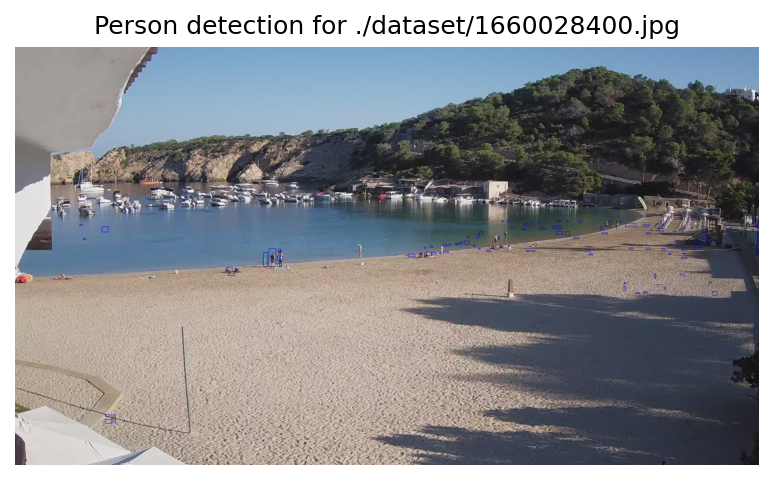

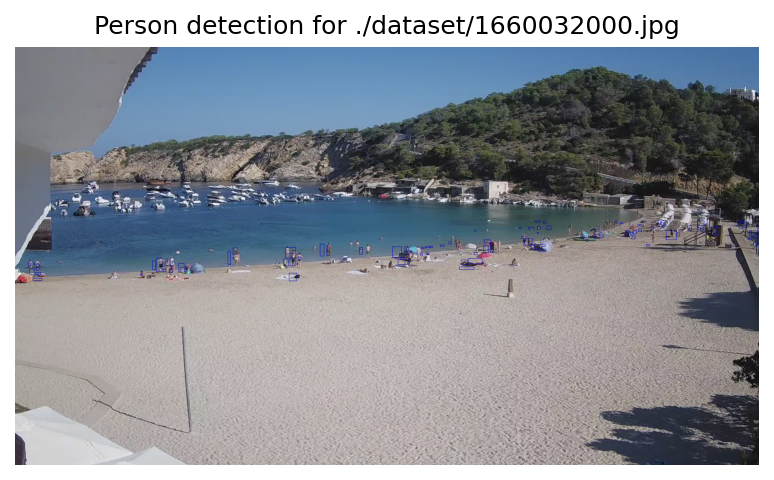

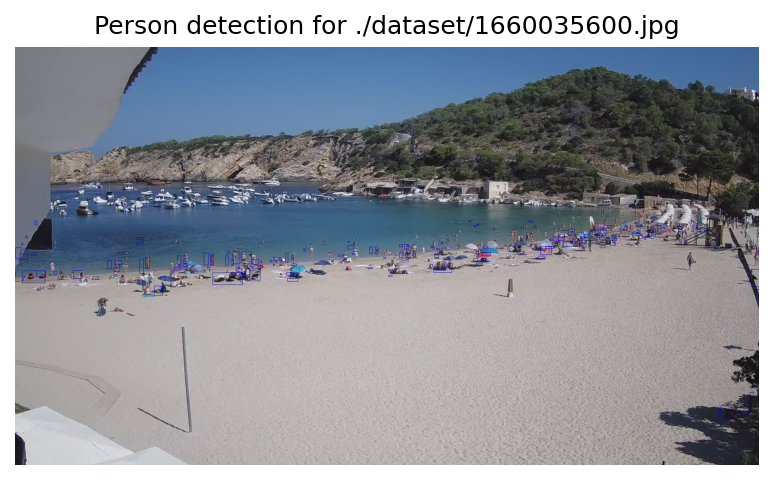

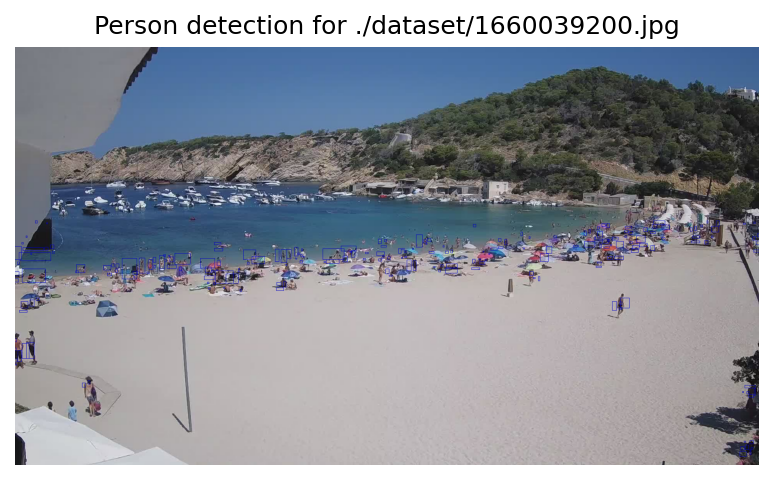

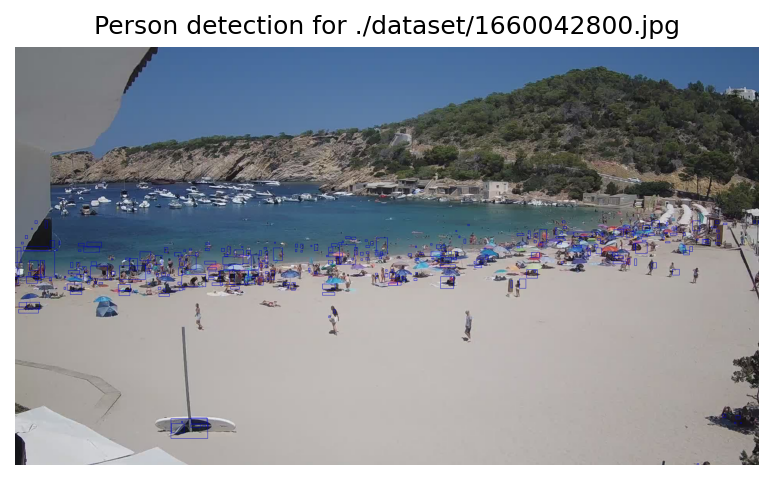

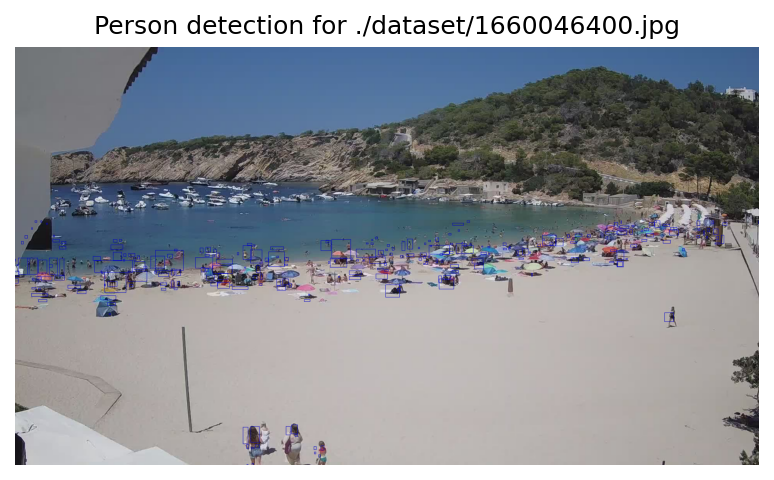

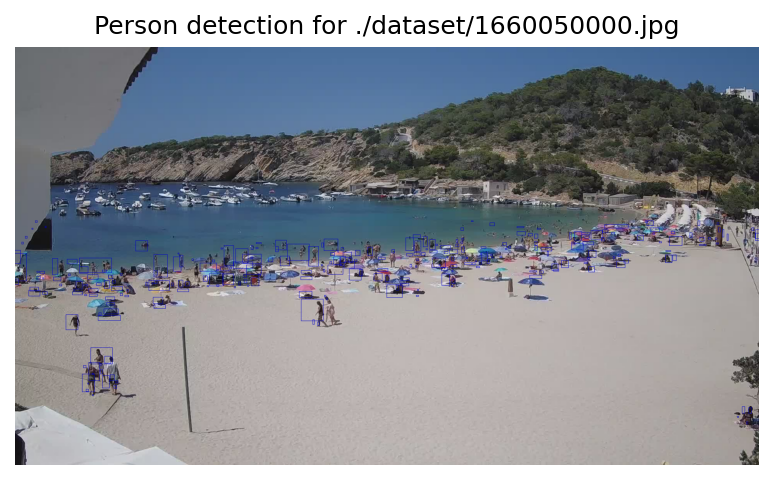

In [10]:
for file_name in file_names:
    current_file_path = "./dataset/" + file_name
    _ = find_person_from_beach_image(current_file_path, True)
    

## Calculating accuracy for image level

Mean Squared Error (MSE) using numpy will be used

In [ ]:
actual_number_of_person = []
recognized_number_of_person = []
for file_name in file_names:
    current_file_df = labels_df.loc[labels_df["file_name"] == file_name]
    current_file_df_len = len(current_file_df)
    current_file_path = "./dataset/" + file_name
    boxes_of_recognized_person = find_person_from_beach_image(current_file_path, False)
    boxes_of_recognized_person_len = len(boxes_of_recognized_person)
    actual_number_of_person.append(current_file_df_len)
    recognized_number_of_person.append(boxes_of_recognized_person_len)

# Calculation of Mean Squared Error (MSE)
mean_squared_error = np.square(np.subtract(actual_number_of_person,recognized_number_of_person)).mean()
print("Mean squared error value is", mean_squared_error)

Mean squared error value is 4327.666666666667


## Calculating person level accuracy

Sensitivity and specificity will be used taking into account the distance between person coordinate and the center of the boundary box coordinate

In [ ]:
recalls= []
precisions = []
csi_values = []
for file_name in file_names:
    current_file_df = labels_df.loc[labels_df["file_name"] == file_name]
    actual_number_of_person = len(current_file_df)
    current_file_path = "./dataset/" + file_name
    actual_x_coords = np.array(current_file_df["x"][:])
    actual_y_coords = np.array(current_file_df["y"][:])
    boxes_of_recognized_person = find_person_from_beach_image(current_file_path, False)
    
    true_positives = 0
    total_boxes = len(boxes_of_recognized_person)
    recognized_x_coords, recognized_y_coords = [], []
    for box in boxes_of_recognized_person:
        x, y, w, h = box[0], box[1], box[2], box[3]
        recognized_x_coords.append(int(x + x + w)//2)
        recognized_y_coords.append(int(y + y + h)//2)
    for x,y in zip(actual_x_coords, actual_y_coords):
        for rec_x, rec_y in zip(recognized_x_coords, recognized_y_coords):
            x_diff = np.abs(rec_x - x)
            y_diff = np.abs(rec_y - y)
            if (x_diff <= 11) and (y_diff <= 11):
                true_positives += 1
                break
    false_negatives = actual_number_of_person - true_positives
    false_positives = total_boxes - true_positives
    recall = np.round(true_positives/actual_number_of_person * 100, 2)
    precision = np.round(true_positives/(true_positives + false_positives) * 100, 2)
    csi_value = np.round(true_positives/(true_positives + false_negatives + false_positives) * 100, 2)
    recalls.append(recall)
    precisions.append(precision)
    csi_values.append(csi_value)
print("Recall", np.mean(recall))
print("Precision", np.mean(precision))
print("Jaccard Index", np.round(np.mean(csi_values), 2))

Recall 50.21
Precision 35.03
Jaccard Index 20.56
